## 1. Data reading

## 2. Data cleaning and filtering

## 3. Data transformation


In [1]:
import polars as pl
from datetime import datetime, time

In [2]:
DATA_DIR = "data"
MONEY_RELATED_COLS = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
]
VALID_VENDOR_IDS = [1, 2, 6, 7]
VALID_RATECODE_IDS = [1, 2, 3, 4, 5, 6, 99]

df = (
    pl.concat(
        [pl.scan_parquet(f"{DATA_DIR}/{month}.parquet") for month in range(1, 6)],
        how="vertical_relaxed",
    )
    .with_columns(
        [
            pl.col("tpep_pickup_datetime").cast(pl.Datetime("us")),
            pl.col("tpep_dropoff_datetime").cast(pl.Datetime("us")),
            pl.col("passenger_count").fill_null(1).clip(0, 6).cast(pl.UInt8),
            (
                (
                    pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")
                ).dt.total_hours()
            ).alias("duration_hours"),
        ]
    )
    .with_columns([pl.col(col).abs() for col in MONEY_RELATED_COLS])
    .with_columns(
        pl.when(pl.col("payment_type") == 1)
        .then(pl.lit("credit_card"))
        .when(pl.col("payment_type") == 2)
        .then(pl.lit("cash"))
        .when(pl.col("payment_type").is_in([0, 3, 4, 5, 6]))
        .then(pl.lit("other"))
        .otherwise(pl.lit("other"))
        .alias("payment_type")
    )
    .filter(
        (pl.col("tpep_pickup_datetime") >= datetime(2024, 1, 1))
        & (pl.col("tpep_pickup_datetime") < datetime(2025, 1, 1))
        & (pl.col("tpep_dropoff_datetime") <= datetime(2025, 1, 1))
        & (pl.col("passenger_count") > 0)
        & (pl.col("duration_hours") <= 2)
        & (pl.max_horizontal(MONEY_RELATED_COLS) <= 1000)
        & pl.col("VendorID").is_in(VALID_VENDOR_IDS)
        & pl.col("RatecodeID").is_in(VALID_RATECODE_IDS)
    )
    .collect()
)

In [3]:
df_taxi_zones = pl.read_csv("data/taxi_zone_lookup.csv")
df_taxi_zones

LocationID,Borough,Zone,service_zone
i64,str,str,str
1,"""EWR""","""Newark Airport""","""EWR"""
2,"""Queens""","""Jamaica Bay""","""Boro Zone"""
3,"""Bronx""","""Allerton/Pelham Gardens""","""Boro Zone"""
4,"""Manhattan""","""Alphabet City""","""Yellow Zone"""
5,"""Staten Island""","""Arden Heights""","""Boro Zone"""
…,…,…,…
261,"""Manhattan""","""World Trade Center""","""Yellow Zone"""
262,"""Manhattan""","""Yorkville East""","""Yellow Zone"""
263,"""Manhattan""","""Yorkville West""","""Yellow Zone"""


In [4]:
result = df.select(
    [
        pl.col("passenger_count").min().alias("passenger_count_min"),
        pl.col("passenger_count").max().alias("passenger_count_max"),
        pl.col("trip_distance").min().alias("trip_distance_min"),
        pl.col("trip_distance").max().alias("trip_distance_max"),
        pl.col("fare_amount").min().alias("fare_amount_min"),
        pl.col("fare_amount").max().alias("fare_amount_max"),
        pl.col("extra").min().alias("extra_min"),
        pl.col("extra").max().alias("extra_max"),
        pl.col("mta_tax").min().alias("mta_tax_min"),
        pl.col("mta_tax").max().alias("mta_tax_max"),
        pl.col("tip_amount").min().alias("tip_amount_min"),
        pl.col("tip_amount").max().alias("tip_amount_max"),
        pl.col("tolls_amount").min().alias("tolls_amount_min"),
        pl.col("tolls_amount").max().alias("tolls_amount_max"),
        pl.col("improvement_surcharge").min().alias("improvement_surcharge_min"),
        pl.col("improvement_surcharge").max().alias("improvement_surcharge_max"),
        pl.col("total_amount").min().alias("total_amount_min"),
        pl.col("total_amount").max().alias("total_amount_max"),
        pl.col("congestion_surcharge").min().alias("congestion_surcharge_min"),
        pl.col("congestion_surcharge").max().alias("congestion_surcharge_max"),
        pl.col("Airport_fee").min().alias("Airport_fee_min"),
        pl.col("Airport_fee").max().alias("Airport_fee_max"),
    ]
)

result

passenger_count_min,passenger_count_max,trip_distance_min,trip_distance_max,fare_amount_min,fare_amount_max,extra_min,extra_max,mta_tax_min,mta_tax_max,tip_amount_min,tip_amount_max,tolls_amount_min,tolls_amount_max,improvement_surcharge_min,improvement_surcharge_max,total_amount_min,total_amount_max,congestion_surcharge_min,congestion_surcharge_max,Airport_fee_min,Airport_fee_max
u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,6,0.0,134298.4,0.0,999.0,0.0,14.25,0.0,35.84,0.0,598.58,0.0,528.56,0.0,1.0,0.0,1000.0,0.0,2.5,0.0,1.75


In [5]:
df_optimized = df.with_columns(
    [
        pl.col("VendorID").cast(pl.Categorical),
        pl.col("RatecodeID").cast(pl.Categorical),
        pl.col("store_and_fwd_flag").cast(pl.Categorical),
        pl.col("PULocationID").cast(pl.Categorical),
        pl.col("DOLocationID").cast(pl.Categorical),
        pl.col("payment_type").cast(pl.Categorical),
        pl.col("passenger_count").cast(pl.UInt8),
        pl.col("trip_distance").cast(pl.Float32),
        pl.col("fare_amount").cast(pl.Float32),
        pl.col("extra").cast(pl.Float32),
        pl.col("mta_tax").cast(pl.Float32),
        pl.col("tip_amount").cast(pl.Float32),
        pl.col("tolls_amount").cast(pl.Float32),
        pl.col("improvement_surcharge").cast(pl.Float32),
        pl.col("total_amount").cast(pl.Float32),
        pl.col("congestion_surcharge").cast(pl.Float32),
        pl.col("Airport_fee").cast(pl.Float32),
    ]
)

df_optimized.head(10)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration_hours
cat,datetime[μs],datetime[μs],u8,f32,cat,cat,cat,cat,cat,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64
null,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,null,"""N""",null,null,"""cash""",17.700001,1.0,0.5,0.0,0.0,1.0,22.700001,2.5,0.0,0
null,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,null,"""N""",null,null,"""credit_card""",10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,0
null,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,null,"""N""",null,null,"""credit_card""",23.299999,3.5,0.5,3.0,0.0,1.0,31.299999,2.5,0.0,0
null,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,null,"""N""",null,null,"""credit_card""",10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0,0
null,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,null,"""N""",null,null,"""credit_card""",7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0,0
null,2024-01-01 00:54:08,2024-01-01 01:26:31,1,4.7,null,"""N""",null,null,"""credit_card""",29.6,3.5,0.5,6.9,0.0,1.0,41.5,2.5,0.0,0
null,2024-01-01 00:49:44,2024-01-01 01:15:47,2,10.82,null,"""N""",null,null,"""credit_card""",45.700001,6.0,0.5,10.0,0.0,1.0,64.949997,0.0,1.75,0
null,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,null,"""N""",null,null,"""cash""",31.0,1.0,0.5,0.0,0.0,1.0,36.0,2.5,0.0,0
null,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,null,"""N""",null,null,"""cash""",3.0,1.0,0.5,0.0,0.0,1.0,8.0,2.5,0.0,0


In [6]:
df = (
    df.join(
        df_taxi_zones.select(["LocationID", "Borough"]),
        left_on="PULocationID",
        right_on="LocationID",
        how="left",
    )
    .rename({"Borough": "PUBorough"})
    .join(
        df_taxi_zones.select(["LocationID", "Borough"]),
        left_on="DOLocationID",
        right_on="LocationID",
        how="left",
    )
    .rename({"Borough": "DOBorough"})
    .drop(["PULocationID", "DOLocationID"])
    .with_columns(
        [
            (pl.col("Airport_fee") > 0).alias("is_airport_ride"),
            (
                (pl.col("tpep_pickup_datetime").dt.weekday() < 5)
                & (
                    pl.col("tpep_pickup_datetime")
                    .dt.time()
                    .is_between(time(6, 30), time(9, 30))
                    | pl.col("tpep_pickup_datetime")
                    .dt.time()
                    .is_between(time(15, 30), time(20, 0))
                )
            ).alias("is_rush_hour"),
        ]
    )
)

## 4. Data transformation


In [7]:
df = (
    df.to_dummies(columns=["payment_type"], separator="_")
    .to_dummies(columns=["Borough_pickup"], separator="_")
    .to_dummies(columns=["Borough_dropoff"], separator="_")
)

In [8]:
date_partition = pl.col("tpep_pickup_datetime").dt.date()

df = df.with_columns(
    [
        pl.len().over(date_partition).alias("total_rides"),
        pl.col("is_airport_ride").sum().over(date_partition).alias("airport_rides"),
        pl.col("is_rush_hour").sum().over(date_partition).alias("rush_hour_rides"),
        
        pl.col("fare_amount").mean().over(date_partition).alias("daily_avg_fare"),
        pl.col("trip_distance").median().over(date_partition).alias("daily_median_distance"),
        pl.col("total_amount").sum().over(date_partition).alias("daily_sum_total_amount"),
        pl.col("congestion_surcharge").sum().over(date_partition).alias("daily_total_congestion_surcharge"),
        pl.col("passenger_count").sum().over(date_partition).alias("daily_total_passengers"),
        
        (pl.col("payment_type_credit_card") * pl.col("total_amount"))
            .sum()
            .over(date_partition)
            .alias("daily_amount_credit_card"),
        
        (pl.col("payment_type_cash") * pl.col("total_amount"))
            .sum()
            .over(date_partition)
            .alias("daily_amount_cash"),
        
        (pl.col("payment_type_other") * pl.col("total_amount"))
            .sum()
            .over(date_partition)
            .alias("daily_amount_other"),
    ]
)

In [9]:
df = df.with_columns(
    [
        pl.col("tpep_pickup_datetime").dt.quarter().alias("quarter"),
        pl.col("tpep_pickup_datetime").dt.month().alias("month"),
        pl.col("tpep_pickup_datetime").dt.day().alias("day_of_month"),
        pl.col("tpep_pickup_datetime").dt.weekday().alias("day_of_week"),
        (pl.col("tpep_pickup_datetime").dt.weekday() >= 5).alias("is_weekend"),
    ]
)

In [10]:
df = df.with_columns(
    pl.col("tpep_pickup_datetime").dt.date().alias("date")
)

In [11]:
df = df.rename({
    "VendorID": "vendor_id",
    "RatecodeID": "rate_code_id",
    "Airport_fee": "airport_fee",
    "PUBorough": "pickup_borough",
    "DOBorough": "dropoff_borough",
    
    "total_rides": "daily_total_rides",
    "airport_rides": "daily_airport_rides",
    "rush_hour_rides": "daily_rush_hour_rides",
    
    "payment_type_credit_card": "is_payment_credit_card",
    "payment_type_cash": "is_payment_cash",
    "payment_type_other": "is_payment_other",
})

In [12]:
df.write_parquet("dataset.parquet")

## 5. Data analysis


In [13]:
df.shape

(15031804, 41)

In [14]:
df.head(10)

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,is_payment_cash,is_payment_credit_card,is_payment_other,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration_hours,pickup_borough,dropoff_borough,is_airport_ride,is_rush_hour,daily_total_rides,daily_airport_rides,daily_rush_hour_rides,daily_avg_fare,daily_median_distance,daily_sum_total_amount,daily_total_congestion_surcharge,daily_total_passengers,daily_amount_credit_card,daily_amount_cash,daily_amount_other,quarter,month,day_of_month,day_of_week,is_weekend,date
i32,datetime[μs],datetime[μs],u8,f64,i64,str,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,bool,bool,u32,u32,u32,f64,f64,f64,f64,i64,f64,f64,f64,i8,i8,i8,i8,bool,date
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""",1,0,0,17.7,1.0,0.5,0.0,0.0,1.0,22.7,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""",0,1,0,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""",0,1,0,23.3,3.5,0.5,3.0,0.0,1.0,31.3,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""",0,1,0,10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""",0,1,0,7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
1,2024-01-01 00:54:08,2024-01-01 01:26:31,1,4.7,1,"""N""",0,1,0,29.6,3.5,0.5,6.9,0.0,1.0,41.5,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
2,2024-01-01 00:49:44,2024-01-01 01:15:47,2,10.82,1,"""N""",0,1,0,45.7,6.0,0.5,10.0,0.0,1.0,64.95,0.0,1.75,0,"""Queens""","""Brooklyn""",true,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
2,2024-01-01 00:26:01,2024-01-01 00:54:12,1,5.44,1,"""N""",1,0,0,31.0,1.0,0.5,0.0,0.0,1.0,36.0,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01
2,2024-01-01 00:28:08,2024-01-01 00:29:16,1,0.04,1,"""N""",1,0,0,3.0,1.0,0.5,0.0,0.0,1.0,8.0,2.5,0.0,0,"""Manhattan""","""Manhattan""",false,false,69670,8353,19398,22.219974,2.09,2.1853e6,156130.75,109145,1.7447e6,384743.61,55778.86,1,1,1,1,false,2024-01-01


In [15]:
df.describe()

statistic,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,is_payment_cash,is_payment_credit_card,is_payment_other,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration_hours,pickup_borough,dropoff_borough,is_airport_ride,is_rush_hour,daily_total_rides,daily_airport_rides,daily_rush_hour_rides,daily_avg_fare,daily_median_distance,daily_sum_total_amount,daily_total_congestion_surcharge,daily_total_passengers,daily_amount_credit_card,daily_amount_cash,daily_amount_other,quarter,month,day_of_month,day_of_week,is_weekend,date
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",1.5031804e7,"""15031804""","""15031804""",1.5031804e7,1.5031804e7,1.5031804e7,"""15031804""",1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,"""15031804""","""15031804""",1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,1.5031804e7,"""15031804"""
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",1.766447,"""2024-03-19 08:25:05.707375""","""2024-03-19 08:41:02.661398""",1.348059,3.439205,2.231482,null,0.150962,0.823953,0.025085,19.276472,1.558672,0.49449,3.536788,0.595002,0.997299,28.371717,2.307701,0.150105,0.017012,null,null,0.085774,0.244878,100512.332887,8482.993325,24812.487857,19.276472,1.699656,2.8508e6,232162.869643,135235.246768,2.4174e6,369731.380349,63658.75526,1.42184,3.083174,15.629024,3.992843,0.417563,"""2024-03-18 17:33:14.072514"""
"""std""",0.423091,null,null,0.823249,84.530917,10.56894,null,0.358012,0.38086,0.156384,18.237123,1.818534,0.053204,4.02952,2.232422,0.051653,22.849966,0.666158,0.490053,0.132196,null,null,null,null,12102.479721,1475.233676,21424.848448,1.057113,0.083263,370403.57965,29553.2991,15684.987071,329578.425426,41697.797134,10623.324308,0.493853,1.41315,8.753328,1.909821,null,null
"""min""",1.0,"""2024-01-01 00:00:00""","""2024-01-01 00:02:42""",1.0,0.0,1.0,"""N""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""Bronx""","""Bronx""",0.0,0.0,13.0,1.0,0.0,16.691075,1.51,372.07,30.0,13.0,276.87,95.2,0.0,1.0,1.0,1.0,1.0,0.0,"""2024-01-01"""
"""25%""",2.0,"""2024-02-10 20:22:53""","""2024-02-10 20:39:25""",1.0,1.0,1.0,null,0.0,1.0,0.0,9.3,0.0,0.5,1.0,0.0,1.0,15.7,2.5,0.0,0.0,null,null,null,null,92237.0,7398.0,0.0,18.566343,1.66,2.5917e6,210780.0,123653.0,2.1994e6,341953.31,54853.08,1.0,2.0,8.0,2.0,null,"""2024-02-10"""
"""50%""",2.0,"""2024-03-20 02:34:25""","""2024-03-20 02:47:07""",1.0,1.7,1.0,null,0.0,1.0,0.0,13.5,1.0,0.5,2.82,0.0,1.0,20.61,2.5,0.0,0.0,null,null,null,null,102360.0,8629.0,37203.0,19.222066,1.7,2.8498e6,236002.5,135847.0,2.4256e6,368435.78,64302.34,1.0,3.0,16.0,4.0,null,"""2024-03-20"""
"""75%""",2.0,"""2024-04-26 08:48:21""","""2024-04-26 09:04:47""",1.0,3.2,1.0,null,0.0,1.0,0.0,21.2,2.5,0.5,4.34,0.0,1.0,29.88,2.5,0.0,0.0,null,null,null,null,109995.0,9519.0,44168.0,20.023923,1.72,3.0772e6,255755.0,146490.0,2.6230e6,407435.0,71477.55,2.0,4.0,23.0,6.0,null,"""2024-04-26"""
"""max""",2.0,"""2024-06-01 23:54:14""","""2024-06-02 00:02:39""",6.0,134298.4,99.0,"""Y""",1.0,1.0,1.0,999.0,14.25,35.84,598.58,528.56,1.0,1000.0,2.5,1.75,2.0,"""Unknown""","""Unknown""",1.0,1.0,123666.0,11914.0,50888.0,22.219974,2.09,3.7436e6,286140.0,169305.0,3.2219e6,451228.63,89857.47,2.0,6.0,31.0,7.0,1.0,"""2024-06-01"""


In [16]:
df.schema

Schema([('vendor_id', Int32),
        ('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='us', time_zone=None)),
        ('passenger_count', UInt8),
        ('trip_distance', Float64),
        ('rate_code_id', Int64),
        ('store_and_fwd_flag', String),
        ('is_payment_cash', UInt8),
        ('is_payment_credit_card', UInt8),
        ('is_payment_other', UInt8),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64),
        ('airport_fee', Float64),
        ('duration_hours', Int64),
        ('pickup_borough', String),
        ('dropoff_borough', String),
        ('is_airport_ride', Boolean),
        ('is_rush_hour', Boolean),
        ('daily_total_rides', UInt32),
        ('daily_airp

In [17]:
plot_data = df.select(["date", "daily_total_rides"]).unique(subset=["date"]).sort("date")

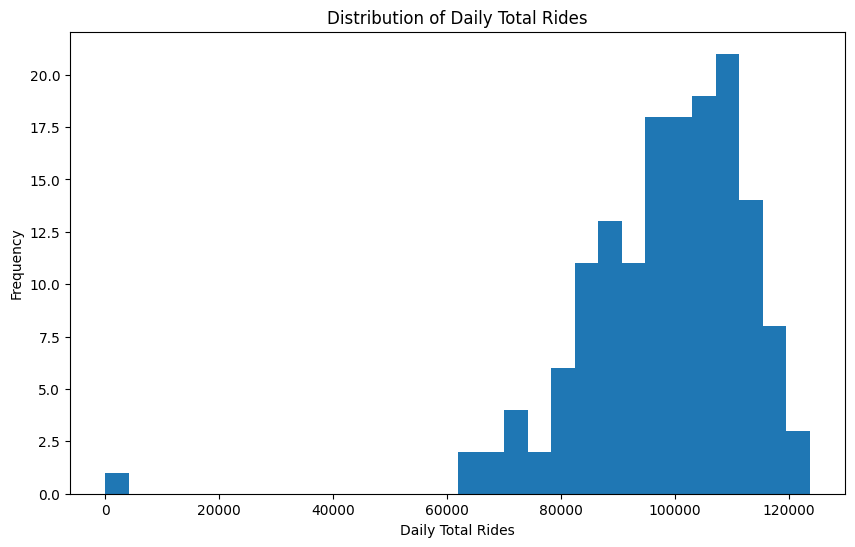

In [18]:
import matplotlib.pyplot as plt

plot_data = plot_data.to_pandas()

plt.figure(figsize=(10, 6))
plt.hist(plot_data["daily_total_rides"], bins=30)
plt.xlabel("Daily Total Rides")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Total Rides")
plt.show()

<Axes: xlabel='date'>

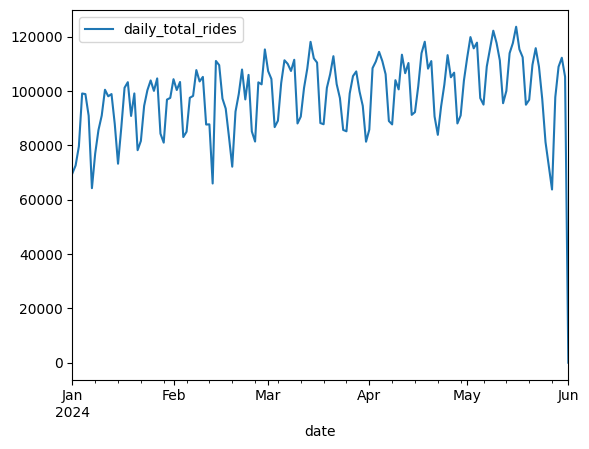

In [20]:
plot_data.plot.line(x="date", y="daily_total_rides")